# R-VGA in a logistic regression problem

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_biclusters
from rebayes_mini import callbacks
from rebayes_mini.methods import recursive_vi_gauss as rvga

In [4]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 15
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rc("text", usetex=True)

sns.set_palette("colorblind")
palette = sns.color_palette()

In [97]:
palette = sns.color_palette()

In [161]:
n_samples = 500
X, y, cls = make_biclusters((n_samples, 2), 2, noise=1.0, minval=-3, maxval=3, random_state=314)
y = y.argmax(axis=0)

angle = jnp.pi * -0.3
R = jnp.array([
    [jnp.cos(angle), -jnp.sin(angle)],
    [jnp.sin(angle), jnp.cos(angle)]
])
X = jnp.einsum("mn,sn->sm", R, X)

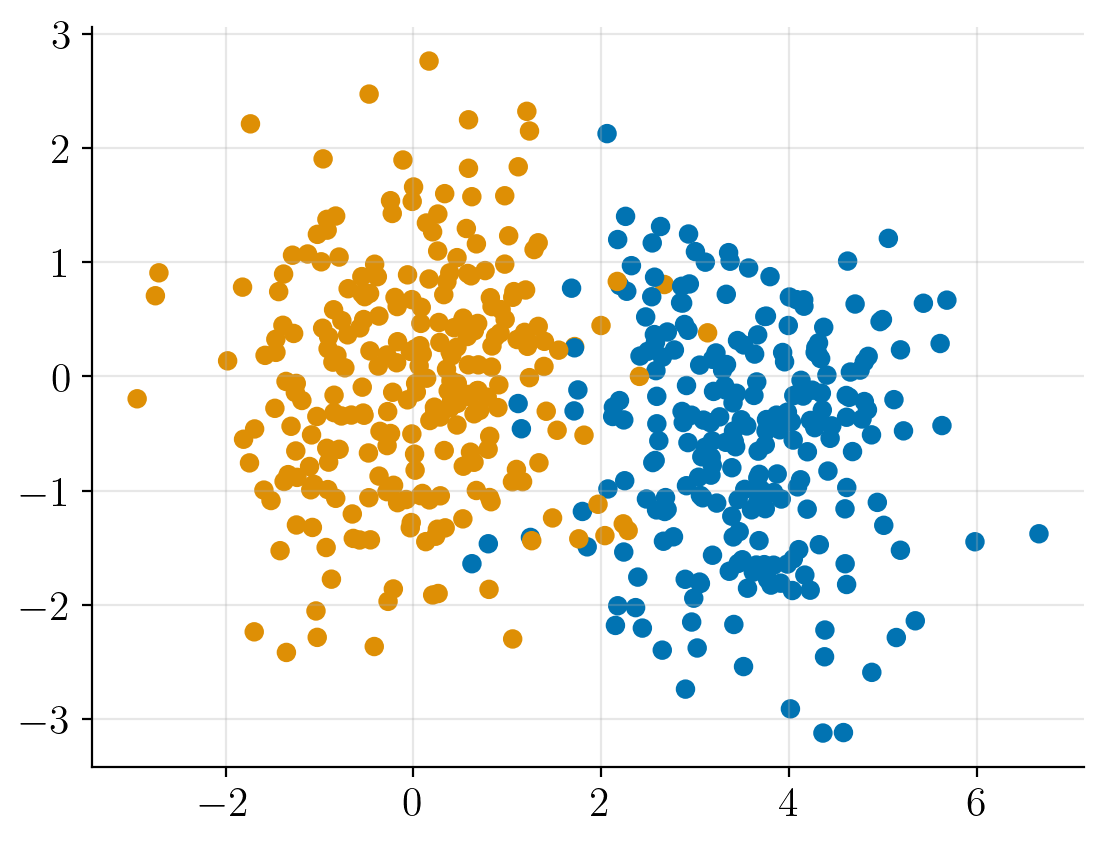

In [166]:
colors = [palette[v] for v in y]
plt.scatter(*X.T, c=colors)
plt.grid(alpha=0.3)

In [90]:
_, dim = X.shape
def apply_fn(w, x):
    return jnp.atleast_1d(w @ x)

rvga_filter = rvga.BernoulliRVGA(apply_fn, n_inner=10, n_samples=30)

key = jax.random.PRNGKey(314)
Phi = jnp.c_[jnp.ones(n_samples), X]
bel_init = rvga_filter.init_bel(jnp.zeros(dim + 1))

In [91]:
bel_final, hist_bel = rvga_filter.scan(key, bel_init, y[:, None], Phi, callbacks.get_updated_bel)

In [92]:
mean_final = bel_final.mean
preds = jnp.einsum("m,tm->t", mean_final, Phi)
preds = jax.nn.sigmoid(preds).round()
(preds == y).mean()

Array(0.95800006, dtype=float32)

In [93]:
x1 = jnp.linspace(-3, 5, 20)
x2 = jnp.linspace(-3, 5, 25)
Z = jnp.mgrid[-3:5:20j,-3:5:25j]
# Z = jnp.einsum("nm,mij->nij", R, Z)
Phi_Z = jnp.concat([jnp.ones((1, 20, 25)), Z], axis=0)

In [94]:
((preds != y) * (y == 0)).sum() # Green dots below

Array(10, dtype=int32)

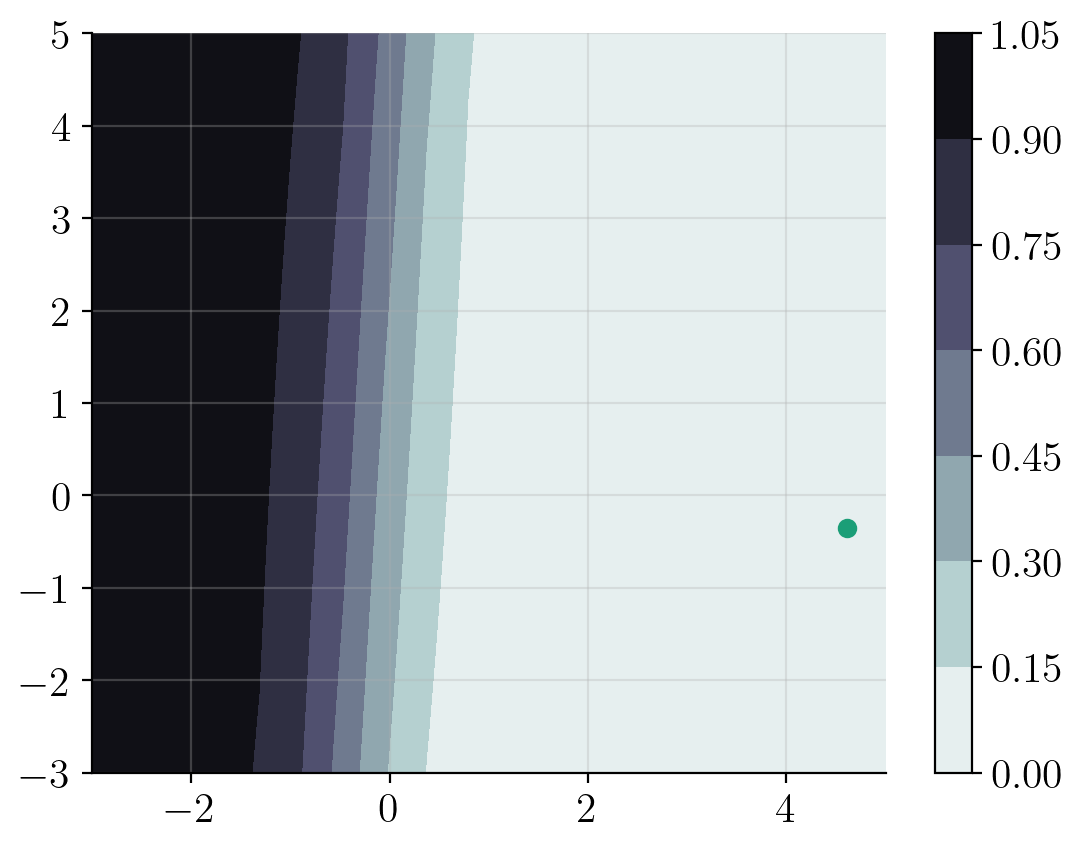

In [95]:
t = 1

bel_mean = hist_bel.mean[t]
S = jax.nn.sigmoid(jnp.einsum("dij,d->ij", Phi_Z, bel_mean))
# S = jnp.einsum("dij,d->ij", Phi_Z, bel_mean)

plt.contourf(x1, x2, S.T, cmap="bone_r")
plt.colorbar()

plt.scatter(*X[:t].T, c=y[:t], cmap="Dark2")
plt.xlim(-3, 5)
plt.ylim(-3, 5)
plt.grid(alpha=0.3)

In [96]:
# bel_mean = jnp.array([0.0, 1.1, 0.8])
# bel_mean = jnp.array([22.0, -10.1, -8])
preds = jax.nn.sigmoid(jnp.einsum("sm,m->s", Phi, bel_mean)) > 0.5
(preds == y).mean()

Array(0.68200004, dtype=float32)

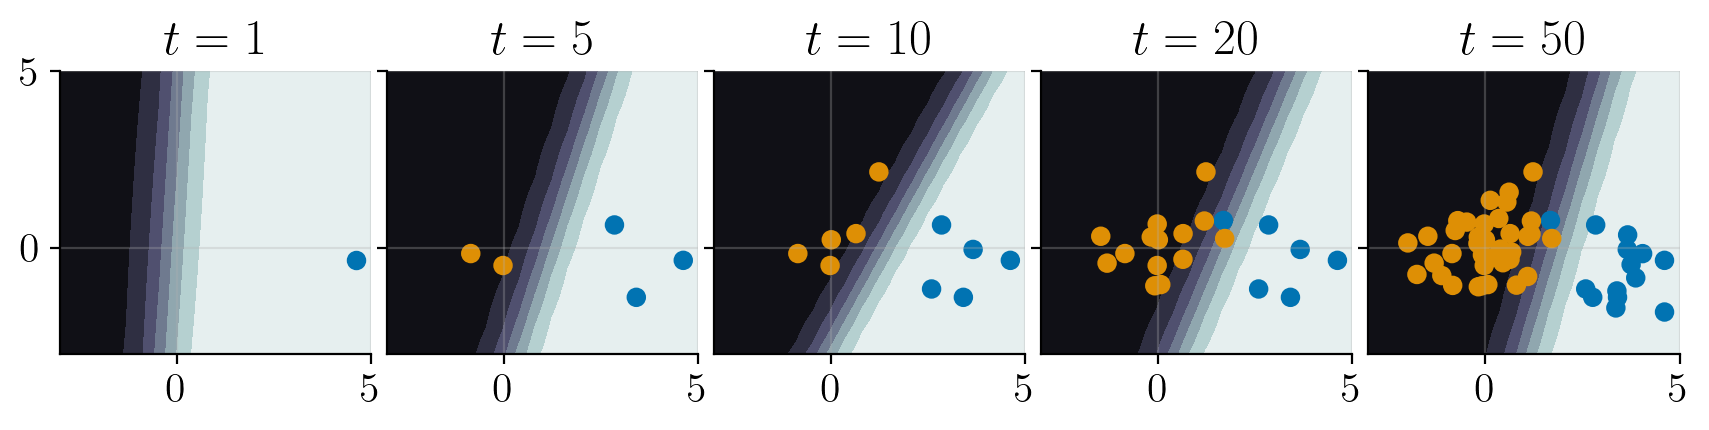

In [107]:
t = 2
# fig, axs = plt.subplots(1, 5, figsize=(10, 3), sharex=True, sharey=True)
fig, axs = plt.subplots(1, 5, figsize=(6.4 * 1.4, 4.8 * 0.5), sharey=True, sharex=True)
t_values = [1, 5, 10, 20, 50]

for axi, t in zip(axs.ravel(), t_values):
    plt.sca(axi)
    bel_mean = hist_bel.mean[t]
    S = jax.nn.sigmoid(jnp.einsum("dij,d->ij", Phi_Z, bel_mean))
    # S = jnp.einsum("dij,d->ij", Phi_Z, bel_mean)
    
    plt.contourf(x1, x2, S.T, cmap="bone_r")

    colors = [palette[v] for v in y[:t]]
    plt.scatter(*X[:t].T, c=colors)
    plt.xlim(-3, 5)
    plt.ylim(-3, 5)
    plt.grid(alpha=0.3)
    plt.title(f"$t={t}$")

plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.0)
plt.savefig("../figures/recursive-logreg.png", dpi=300, bbox_inches="tight")

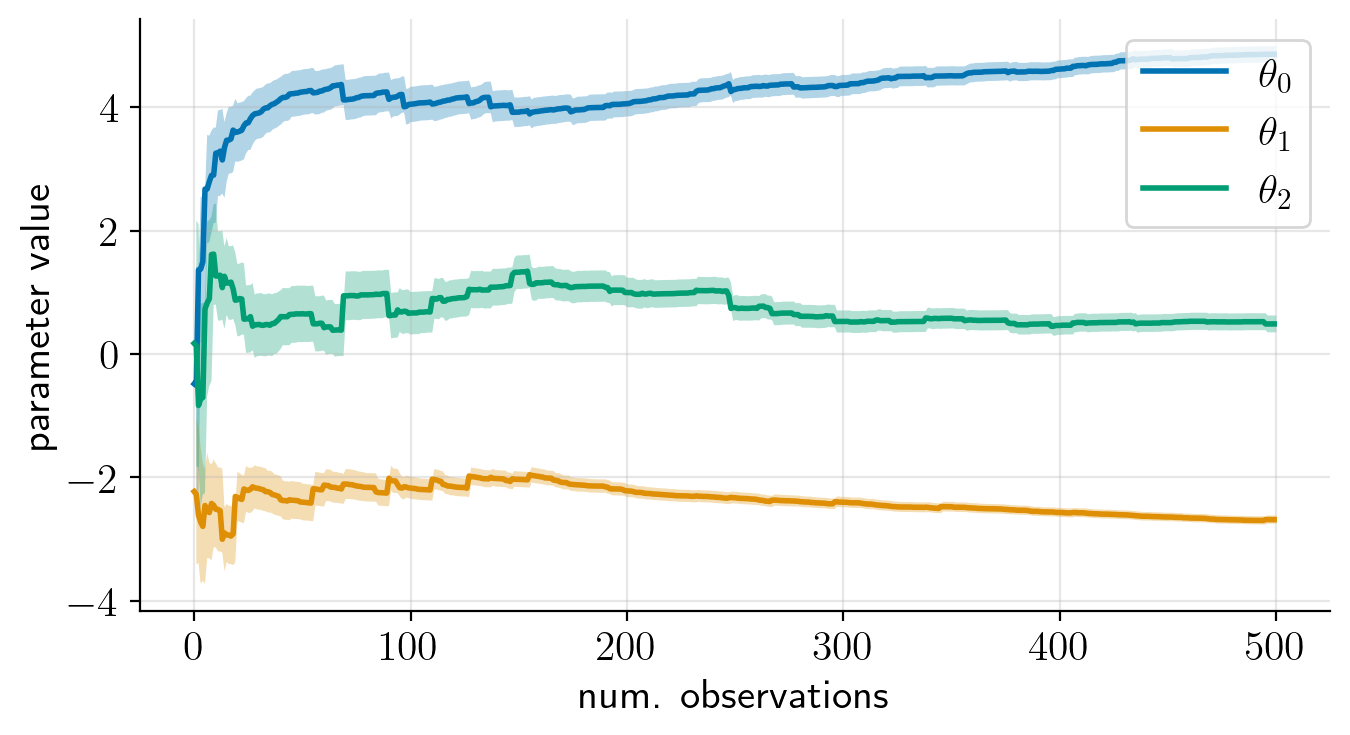

In [156]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 0.8))
sttdevs = np.sqrt(1 / jnp.einsum("sii->si", hist_bel.precision))

colors = palette[:3]
timesteps = np.arange(1, n_samples + 1)
for i, c in enumerate(colors):
    lbound = hist_bel.mean[:, i] - 2 * sttdevs[:, i]
    ubound = hist_bel.mean[:, i] + 2 * sttdevs[:, i]
    plt.fill_between(timesteps, lbound, ubound, alpha=0.3)
    plt.plot(hist_bel.mean[:, i], label=rf"$\theta_{i}$")
plt.legend(loc="upper right")
plt.xlabel("num. observations")
plt.ylabel("parameter value")
plt.grid(alpha=0.3)
plt.savefig("../figures/recursive-logreg-params.png", dpi=300, bbox_inches="tight")

## Increasing dimension

In [125]:
n_samples = 500
dim = 50
X, y, cls = make_biclusters((n_samples, dim), 2, noise=1.2, minval=-3, maxval=3, random_state=314)
y = y.argmax(axis=0)

In [126]:
X = jnp.array(X)
y = jnp.array(y)

In [127]:
def apply_fn(w, x):
    return jnp.atleast_1d(w @ x)

rvga_filter = rvga.BernoulliRVGA(apply_fn, n_inner=5, n_samples=10)

Phi = jnp.c_[jnp.ones(n_samples), X]
bel_init = rvga_filter.init_bel(jnp.zeros(dim + 1))

In [128]:
key = jax.random.PRNGKey(314)
n_runs = 20

@jax.vmap
def run_and_pred(key):
    _, mean_hist = rvga_filter.scan(key, bel_init, y[:, None], Phi)
    
    preds = jnp.einsum("tm,tm->t", mean_hist[:-1], Phi[1:])
    preds = jax.nn.sigmoid(preds).round()
    return preds


In [129]:
keys = jax.random.split(key, n_runs)
preds = run_and_pred(keys)
preds = np.array(preds)

TypeError: 'NoneType' object is not subscriptable

In [ ]:
np.nanmean(preds, axis=1)

In [299]:

(preds == y[1:]).mean()

Array(0.43136272, dtype=float32)

In [ ]:
pd.Series(preds == y[1:]).expanding(20).mean().plot()
plt.grid(alpha=0.3)